In [64]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines.common.env_checker import check_env

# Case Study : Smart AC

In [1]:
from gym import Env
from gym.spaces import Discrete
import numpy as np
import random
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

### Define Our Custom Environment

In [68]:
class SmartAC(Env):
    def __init__(self):
        self.action_space = Discrete(3) # [0, 1, 2]
        self.observation_space = Discrete(100) # Integers from 0-99
        self.state = 35 + random.randint(-5,5)
        self.time_length = 100
        
    def step(self, action):
        
        self.state += (action-1) # Change temperature by -1, 0, or -1
        self.time_length -= 1 
        
        if self.state >=23 and self.state <=25: 
            reward = 1
        else: 
            reward = -1 
        
        if self.time_length <= 0: 
            done = True
        else:
            done = False
        
        self.state += random.randint(-3,3)
        if self.state < 0:
            self.state = 0
        elif self.state > 100:
            self.state = 100
            
        info = {}
        
        return self.state, reward, done, info
    
    def reset(self):
        self.state = 35 + random.randint(-5,5)
        self.time_length = 100 
        return self.state

### Initialize and Test Our SmartAC Environment

In [69]:
# Create and check our custom environment

env =  SmartAC()
print(check_env(env, warn=True))

None


In [88]:
print('Before training .......')
for ep in range(5):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print(f'Test #{ep+1} : Score = {score}')

Before training .......
Test #1 : Score = -78
Test #2 : Score = -76
Test #3 : Score = -100
Test #4 : Score = -86
Test #5 : Score = -80


### Import PPO Algorithm for Model Training

In [80]:
model = PPO("MlpPolicy", env, verbose=1, device = 'cpu')
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=50, verbose=1) # Callbacks Settings
eval_callback = EvalCallback(env, callback_on_new_best=stop_callback, eval_freq=10000, verbose=1)


model.learn(total_timesteps=50000, callback=eval_callback)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 2.6      |
| time/              |          |
|    fps             | 3390     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.1         |
| time/                   |              |
|    fps                  | 2039         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0031298662 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.383       |
|    explained_variance   | 0.362        |
|    learning_r

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 1.2      |
| time/              |          |
|    fps             | 1501     |
|    iterations      | 10       |
|    time_elapsed    | 13       |
|    total_timesteps | 20480    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.84         |
| time/                   |              |
|    fps                  | 1504         |
|    iterations           | 11           |
|    time_elapsed         | 14           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0033735866 |
|    clip_fraction        | 0.0415       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.266       |
|    explained_variance   | 0.413   

Eval num_timesteps=40000, episode_reward=3.20 +/- 7.86
Episode length: 100.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 100          |
|    mean_reward          | 3.2          |
| time/                   |              |
|    total timesteps      | 40000        |
| train/                  |              |
|    approx_kl            | 0.0014338676 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.198        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.2          |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00233     |
|    value_loss           | 21.9         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 4.56     |
| t

In [81]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f'Mean Score = {mean_reward:.2f} \nSD : {std_reward:.2f}')

Mean Score = -1.40 
SD : 16.30


### Comparison Between Trained/Non-Trained Model

In [131]:
fresh_model = PPO("MlpPolicy", env, verbose=0, device = 'cpu') # Non-Trained model baseline
before_training = []
after_training = []

print('Before training .......')
for ep in range(1000):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        try:
            action = fresh_model.predict(state)[0]
        except:
            pass
        state, reward, done, info = env.step(action)
        score+=reward
    before_training.append(score)
    print(f'Test #{ep+1} : Score = {score}')

print('After training .......')
for ep in range(1000):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = model.predict(state)[0]
        state, reward, done, info = env.step(action)
        score+=reward
    after_training.append(score)
    print(f'Test #{ep+1} : Score = {score}')

Before training .......
Test #1 : Score = -70
Test #2 : Score = -96
Test #3 : Score = -100
Test #4 : Score = -100
Test #5 : Score = -78
Test #6 : Score = -44
Test #7 : Score = -88
Test #8 : Score = -100
Test #9 : Score = -60
Test #10 : Score = -100
Test #11 : Score = -100
Test #12 : Score = -100
Test #13 : Score = -86
Test #14 : Score = -92
Test #15 : Score = -58
Test #16 : Score = -100
Test #17 : Score = -76
Test #18 : Score = -82
Test #19 : Score = -100
Test #20 : Score = -90
Test #21 : Score = -80
Test #22 : Score = -96
Test #23 : Score = -40
Test #24 : Score = -96
Test #25 : Score = -92
Test #26 : Score = -54
Test #27 : Score = -100
Test #28 : Score = -86
Test #29 : Score = -74
Test #30 : Score = -70
Test #31 : Score = -56
Test #32 : Score = -100
Test #33 : Score = -100
Test #34 : Score = -96
Test #35 : Score = -100
Test #36 : Score = -100
Test #37 : Score = -100
Test #38 : Score = -80
Test #39 : Score = -92
Test #40 : Score = -96
Test #41 : Score = -100
Test #42 : Score = -92
Test

Test #341 : Score = -80
Test #342 : Score = -100
Test #343 : Score = -88
Test #344 : Score = -56
Test #345 : Score = -100
Test #346 : Score = -92
Test #347 : Score = -92
Test #348 : Score = -100
Test #349 : Score = -98
Test #350 : Score = -100
Test #351 : Score = -92
Test #352 : Score = -92
Test #353 : Score = -100
Test #354 : Score = -100
Test #355 : Score = -100
Test #356 : Score = -92
Test #357 : Score = -84
Test #358 : Score = -98
Test #359 : Score = -90
Test #360 : Score = -100
Test #361 : Score = -76
Test #362 : Score = -100
Test #363 : Score = -86
Test #364 : Score = -98
Test #365 : Score = -100
Test #366 : Score = -92
Test #367 : Score = -66
Test #368 : Score = -98
Test #369 : Score = -100
Test #370 : Score = -84
Test #371 : Score = -72
Test #372 : Score = -86
Test #373 : Score = -100
Test #374 : Score = -86
Test #375 : Score = -100
Test #376 : Score = -100
Test #377 : Score = -76
Test #378 : Score = -62
Test #379 : Score = -84
Test #380 : Score = -92
Test #381 : Score = -86
Te

Test #678 : Score = -100
Test #679 : Score = -90
Test #680 : Score = -100
Test #681 : Score = -76
Test #682 : Score = -70
Test #683 : Score = -92
Test #684 : Score = -86
Test #685 : Score = -100
Test #686 : Score = -100
Test #687 : Score = -100
Test #688 : Score = -100
Test #689 : Score = -46
Test #690 : Score = -100
Test #691 : Score = -100
Test #692 : Score = -52
Test #693 : Score = -66
Test #694 : Score = -80
Test #695 : Score = -100
Test #696 : Score = -96
Test #697 : Score = -78
Test #698 : Score = -78
Test #699 : Score = -78
Test #700 : Score = -90
Test #701 : Score = -100
Test #702 : Score = -84
Test #703 : Score = -84
Test #704 : Score = -60
Test #705 : Score = -50
Test #706 : Score = -86
Test #707 : Score = -100
Test #708 : Score = -100
Test #709 : Score = -94
Test #710 : Score = -100
Test #711 : Score = -52
Test #712 : Score = -98
Test #713 : Score = -100
Test #714 : Score = -76
Test #715 : Score = -96
Test #716 : Score = -46
Test #717 : Score = -90
Test #718 : Score = -100
T

Test #22 : Score = 16
Test #23 : Score = 16
Test #24 : Score = -4
Test #25 : Score = 2
Test #26 : Score = -28
Test #27 : Score = -2
Test #28 : Score = -18
Test #29 : Score = -24
Test #30 : Score = -8
Test #31 : Score = 32
Test #32 : Score = 38
Test #33 : Score = 0
Test #34 : Score = 30
Test #35 : Score = 30
Test #36 : Score = 26
Test #37 : Score = 12
Test #38 : Score = 30
Test #39 : Score = -6
Test #40 : Score = 22
Test #41 : Score = -16
Test #42 : Score = -20
Test #43 : Score = -12
Test #44 : Score = 2
Test #45 : Score = 4
Test #46 : Score = -12
Test #47 : Score = 8
Test #48 : Score = 16
Test #49 : Score = 18
Test #50 : Score = 18
Test #51 : Score = 36
Test #52 : Score = 12
Test #53 : Score = -20
Test #54 : Score = 36
Test #55 : Score = -6
Test #56 : Score = 40
Test #57 : Score = 8
Test #58 : Score = -8
Test #59 : Score = -6
Test #60 : Score = -2
Test #61 : Score = 22
Test #62 : Score = -4
Test #63 : Score = -44
Test #64 : Score = 16
Test #65 : Score = 4
Test #66 : Score = 6
Test #67 

Test #390 : Score = 0
Test #391 : Score = 4
Test #392 : Score = 4
Test #393 : Score = -40
Test #394 : Score = -2
Test #395 : Score = -2
Test #396 : Score = 24
Test #397 : Score = 26
Test #398 : Score = 18
Test #399 : Score = 16
Test #400 : Score = -12
Test #401 : Score = -4
Test #402 : Score = 12
Test #403 : Score = -2
Test #404 : Score = -18
Test #405 : Score = 28
Test #406 : Score = 12
Test #407 : Score = 30
Test #408 : Score = -28
Test #409 : Score = 38
Test #410 : Score = 20
Test #411 : Score = 22
Test #412 : Score = -18
Test #413 : Score = 12
Test #414 : Score = 6
Test #415 : Score = 46
Test #416 : Score = 4
Test #417 : Score = 20
Test #418 : Score = 0
Test #419 : Score = -4
Test #420 : Score = -26
Test #421 : Score = 8
Test #422 : Score = -10
Test #423 : Score = 22
Test #424 : Score = 2
Test #425 : Score = 26
Test #426 : Score = 22
Test #427 : Score = 30
Test #428 : Score = -8
Test #429 : Score = -12
Test #430 : Score = 14
Test #431 : Score = -18
Test #432 : Score = 18
Test #433 

Test #751 : Score = 8
Test #752 : Score = -10
Test #753 : Score = -20
Test #754 : Score = 16
Test #755 : Score = -8
Test #756 : Score = 34
Test #757 : Score = 4
Test #758 : Score = 4
Test #759 : Score = 2
Test #760 : Score = -12
Test #761 : Score = 6
Test #762 : Score = 20
Test #763 : Score = 26
Test #764 : Score = -10
Test #765 : Score = 8
Test #766 : Score = 10
Test #767 : Score = 14
Test #768 : Score = -6
Test #769 : Score = 6
Test #770 : Score = -8
Test #771 : Score = 10
Test #772 : Score = -28
Test #773 : Score = -16
Test #774 : Score = 14
Test #775 : Score = 2
Test #776 : Score = 8
Test #777 : Score = 0
Test #778 : Score = 38
Test #779 : Score = 10
Test #780 : Score = 4
Test #781 : Score = 2
Test #782 : Score = -18
Test #783 : Score = 18
Test #784 : Score = -2
Test #785 : Score = 2
Test #786 : Score = 44
Test #787 : Score = -10
Test #788 : Score = -4
Test #789 : Score = -4
Test #790 : Score = 22
Test #791 : Score = 2
Test #792 : Score = 0
Test #793 : Score = 16
Test #794 : Score 

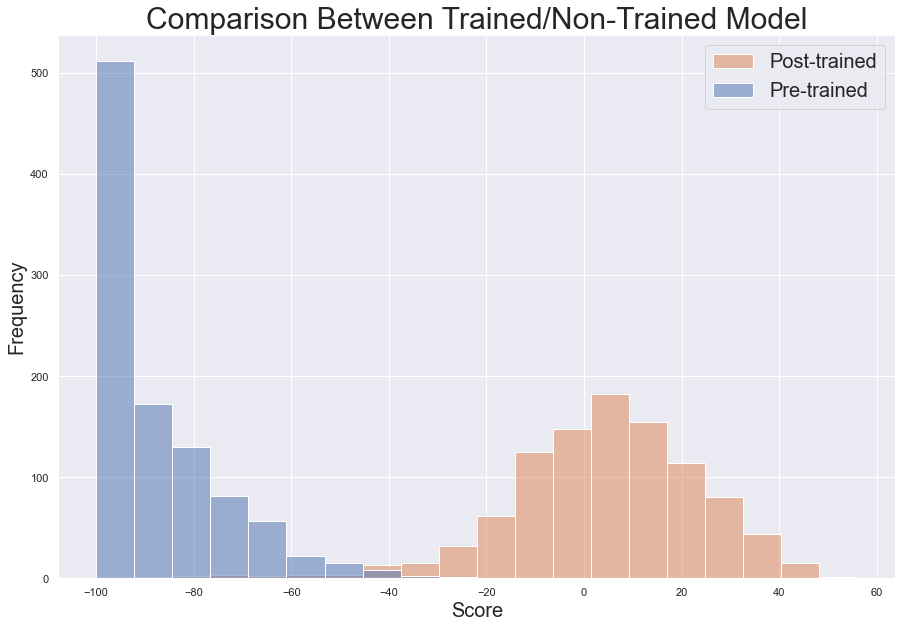

In [154]:
# Plot the result
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.figure(figsize=(15,10))
sns.histplot([before_training, after_training], alpha=0.5, bins=20, legend=False)
plt.legend(labels=['Post-trained', 'Pre-trained'], fontsize=20)
plt.title('Comparison Between Trained/Non-Trained Model', fontsize=30)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Score', fontsize=20)
plt.show()